In [8]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"cjunbot","key":"61451fad6e5168f764531bd88e71fc85"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c titanic

%cd /content/

!unzip -qq "/content/titanic.zip"


mkdir: cannot create directory ‘/root/.kaggle’: File exists
titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
/content
replace gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


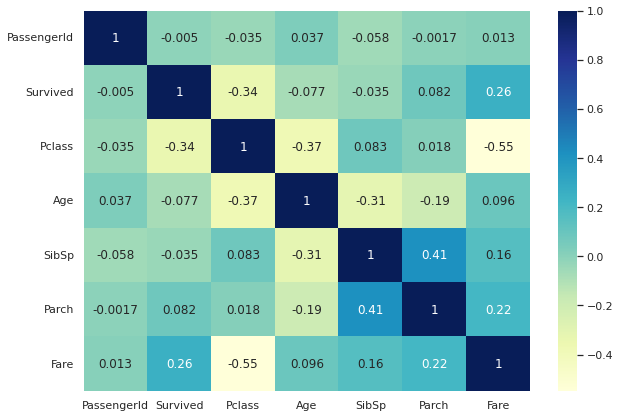

In [9]:
import pandas as pd
import seaborn as sns
import numpy as np

train = pd.read_csv('/content/train.csv')
train.head()

test = pd.read_csv('/content/test.csv')

sns.set(rc = {'figure.figsize':(10,7)})
sns.heatmap(train.corr(), annot = True, fmt='.2g',cmap= 'YlGnBu')


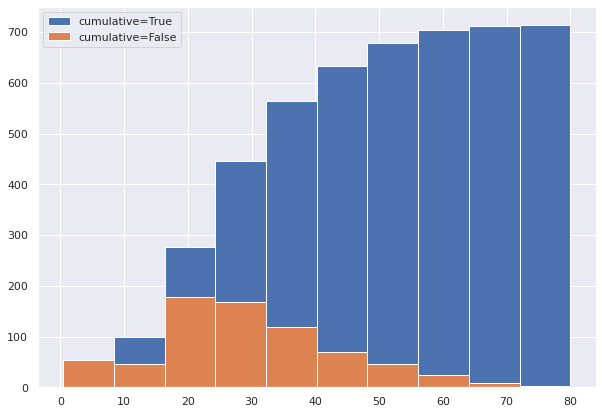

In [ ]:
plt.hist(train['Age'], cumulative=True, label='cumulative=True')
plt.hist(train['Age'], cumulative=False, label='cumulative=False')
plt.legend()
plt.show()

In [ ]:
print("Train data missed values:\n")
print(train.isnull().sum())
print("-----------------------------------")
print("Test data missed values:\n")
print(test.isnull().sum())


Train data missed values:

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
-----------------------------------
Test data missed values:

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [ ]:
train.describe()

train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


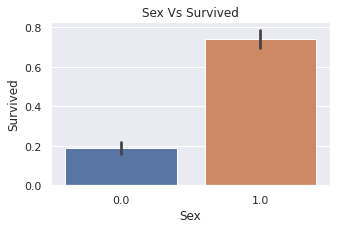

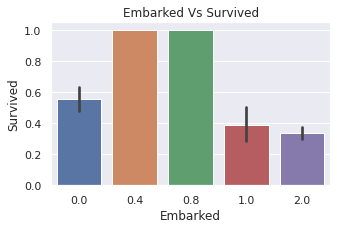

In [26]:
import matplotlib.pyplot as plt

def survived_table(feature):
    return train[[feature, "Survived"]].groupby([feature], as_index=False).mean().sort_values(by='Survived', ascending=False).style.background_gradient(low=0.75,high=1)

def survived_bar_plot(feature):
    plt.figure(figsize = (5,3))
    sns.barplot(data = train , x = feature , y = "Survived").set_title(f"{feature} Vs Survived")
    plt.show()

survived_bar_plot('Sex')
survived_bar_plot('Embarked')

In [10]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)


# 필요 없는 col 지우기
train.drop(columns = ["PassengerId", "Ticket", "Cabin", "Name"] , inplace = True)
test_pd = test["PassengerId"] # 모델 추론을 위해 미리 뽑아놓음
test.drop(columns = ["PassengerId", "Ticket", "Cabin", "Name"] , inplace = True)

# Embarked변수 numercial data로
for index, embark in enumerate(['C', 'Q', 'S']):
  train.loc[(train['Embarked'] == embark), 'Embarked'] = index
  test.loc[(test['Embarked'] == embark), 'Embarked'] = index

# Sex변수 numercial data로
for index_, sex in enumerate(['male', 'female']):
  train.loc[(train['Sex'] == sex), 'Sex'] = index_
  test.loc[(test['Sex'] == sex), 'Sex'] = index_

# KNN을 이용한 결측치 채우기
train = pd.DataFrame(imputer.fit_transform(train), columns = train.columns)
test = pd.DataFrame(imputer.fit_transform(test), columns = test.columns)

#최대최소 정규화
train['Age'] = (train['Age'] - train['Age'].min())/(train['Age'].max()-train['Age'].min())
train['Fare'] = (train['Fare'] - train['Fare'].min())/(train['Fare'].max()-train['Fare'].min())
test['Age'] = (test['Age'] - test['Age'].min())/(test['Age'].max()-test['Age'].min())
test['Fare'] = (test['Fare'] - test['Fare'].min())/(test['Fare'].max()-test['Fare'].min())

train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,3.0,0.0,0.271174,1.0,0.0,0.014151,2.0
1,1.0,1.0,1.0,0.472229,1.0,0.0,0.139136,0.0
2,1.0,3.0,1.0,0.321438,0.0,0.0,0.015469,2.0
3,1.0,1.0,1.0,0.434531,1.0,0.0,0.103644,2.0
4,0.0,3.0,0.0,0.434531,0.0,0.0,0.015713,2.0


In [11]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)

train = pd.DataFrame(imputer.fit_transform(train), columns = train.columns)
test = pd.DataFrame(imputer.fit_transform(test), columns = test.columns)
train.head(10)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,3.0,0.0,0.271174,1.0,0.0,0.014151,2.0
1,1.0,1.0,1.0,0.472229,1.0,0.0,0.139136,0.0
2,1.0,3.0,1.0,0.321438,0.0,0.0,0.015469,2.0
3,1.0,1.0,1.0,0.434531,1.0,0.0,0.103644,2.0
4,0.0,3.0,0.0,0.434531,0.0,0.0,0.015713,2.0
5,0.0,3.0,0.0,0.595376,0.0,0.0,0.016510,1.0
6,0.0,1.0,0.0,0.673285,0.0,0.0,0.101229,2.0
7,0.0,3.0,0.0,0.019854,3.0,1.0,0.041136,2.0
8,1.0,3.0,1.0,0.334004,0.0,2.0,0.021731,2.0
9,1.0,2.0,1.0,0.170646,1.0,0.0,0.058694,0.0


In [12]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset


y_train , x_train  = train["Survived"].astype('float64'),  train.drop(labels = ["Survived"],axis = 1)
x_train = torch.tensor(x_train.values.astype(np.float32))
y_train = torch.tensor(y_train.values.astype(np.float32)).reshape(891, 1)

dataset = TensorDataset(x_train, y_train)

test_size = int(len(dataset)*0.2)
train_size = len(dataset)- int(len(dataset)*0.2)

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Training Data Size : {len(train_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True)

Training Data Size : 713
Testing Data Size : 178


In [66]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(7, 50),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(50,10),
            nn.ReLU(),
            nn.Linear(10,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
loss_function = nn.BCELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)
epochs = 1000

In [67]:
loss_min = np.Inf
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    for batch, (x_batch, y_batch) in enumerate(train_dataloader):
      prediction_ = model(x_batch)
      loss = loss_function(input=prediction_, target=y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch % 10 == 0:
        prediction = prediction_ >= torch.FloatTensor([0.5])
        correct_prediction = prediction.float() == y_batch
        accuracy = correct_prediction.sum().item() / len(correct_prediction)
        current, size = len(x_batch)*batch, (len(train_dataloader.dataset))
        print(f"Loss: {loss:>4f}, Accuracy: {accuracy*100:.2f}% | [{current:>5d}/{size:>5d}]")

      if loss <= loss_min:
        print('==== Loss decreased ({:6f} ===> {:6f}). Saving the model! ===='.format(loss_min, loss))
        torch.save(model.state_dict(), 'model.pth')
        loss_min = loss

    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            pred = model(X)
            test_loss += loss_function(pred, y)
            pred = pred >= torch.FloatTensor([0.5])
            correct += (pred.float() == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Loss: 0.491365, Accuracy: 81.25% | [  480/  713]
Loss: 0.294165, Accuracy: 87.50% | [  640/  713]
Test Error: 
 Accuracy: 81.5%, Avg loss: 0.402454 

Epoch 502
-------------------------------
Loss: 0.350306, Accuracy: 87.50% | [    0/  713]
Loss: 0.261693, Accuracy: 93.75% | [  160/  713]
Loss: 0.647582, Accuracy: 75.00% | [  320/  713]
Loss: 0.382186, Accuracy: 81.25% | [  480/  713]
Loss: 0.445354, Accuracy: 75.00% | [  640/  713]
Test Error: 
 Accuracy: 80.9%, Avg loss: 0.403379 

Epoch 503
-------------------------------
Loss: 0.603426, Accuracy: 75.00% | [    0/  713]
Loss: 0.288769, Accuracy: 87.50% | [  160/  713]
Loss: 0.787659, Accuracy: 62.50% | [  320/  713]
Loss: 0.569073, Accuracy: 68.75% | [  480/  713]
Loss: 0.384822, Accuracy: 87.50% | [  640/  713]
Test Error: 
 Accuracy: 80.9%, Avg loss: 0.404274 

Epoch 504
-------------------------------
Loss: 0.463604, Accuracy: 81.25% | [    0/  713]
Loss: 0.366006, Accuracy: 87.50% | [  160/  7

In [68]:
with torch.no_grad():
    model.eval()
    model.load_state_dict(torch.load("model.pth"))
    #test = torch.tensor(test.values.astype(np.float32))
    #test_pd = torch.tensor(test_pd.values.astype(np.float32))
    outputs_ = model(test)

    outputs = outputs_ >= torch.FloatTensor([0.5])
    outputs = outputs.float()
    print(outputs.shape)
    test_pd = test_pd.reshape(418,1)
    print(test_pd.shape)
    passengerid = pd.DataFrame(data=test_pd.numpy(), dtype=np.int32, columns=['PassengerId'])
    survived = pd.DataFrame(data=outputs.numpy(), dtype=np.int32, columns=['Survived'])
    submission = pd.concat([passengerid, survived], axis=1)
    submission.to_csv('/content/submission.csv', index=False)


torch.Size([418, 1])
torch.Size([418, 1])
